In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import random

from tqdm import tqdm
%matplotlib inline

In [2]:
filepath = "D:\\NDSC 2020\\pre-product-matching-id-ndsc-2020\\"
df = pd.read_csv(filepath + "new_training_set.csv")
df.head()

,Unnamed: 0,title_1,image_1,title_2,image_2,Label
0,0,Johnson’s ® Top to Toe Hair & Body Bath 500ml,fdff8b9b8229da091dd7d070aae05f81.jpg,Johnson's cottontouch top to toe hair & body b...,41e191742760932598c7bd201e5dad47.jpg,0
1,1,Sandal Humble,906cc44f0be72d4e767669b5b63e3a17.jpg,Sandal Humble Glass - Glanzton,7a556b836bfdd08ea592216440524a34.jpg,0
2,2,PROMO LIKUID LIKUIT LIQUIT BABY POD LIQUID SAL...,475c26635de18b9f93032400732ff336.jpg,Voporizer Liquit - Likuit - Likuid - Liquid Pr...,ace93bec689f3f1565800c500a8341fa.jpg,0
3,3,6 Pasang / Set Anting Tusuk Bentuk Lingkaran A...,e630997f6217555d6026547ad1c15f0b.jpg,Subei 6 Pasang / Set Anting Tusuk Boho Bohemia...,31abbc176b09f5bd1728cfc3ecbbfb9c.jpg,0
4,4,ROREC NATURAL SKIN CARE MASK ROREC SHEET MASK ...,a27d11700a7902febd039dc3a96f10f2.jpg,Rorec 86 Natural Skin Care Shert Mask All Variant,813ad9dd638c10f1765db9dde20c9e42.jpg,1


In [3]:
dataset_path = 'D://NDSC 2020//pre-product-matching-id-ndsc-2020//training_img//training_img//'

def feature_match_toolkit(k):
    # read image
    img1 = cv2.imread(dataset_path + df.image_1[k])  
    img2 = cv2.imread(dataset_path + df.image_2[k])  

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    img1 = cv2.resize(img1, (224,224))
    img2 = cv2.resize(img2, (224,224))
    
    # find keypoints dan desc
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 5) # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    goodness = []
    for i, (m,n) in enumerate(matches):
        if m.distance < 0.75*n.distance:
            matchesMask[i] = [1,0]
            goodness.append([m])

    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)

    img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

    fig = plt.figure(figsize = (20,8))
    ax = fig.gca()
    plt.imshow(img3)
    ax.axis(False)
    
    sent1 = "Title_Left: " + df.title_1[k] + "\n Title_Right: " + df.title_2[k]
    sent2 = "\nEdgePoint 1: " + str(len(kp1)) + ", EdgePoint 2: " + str(len(kp2))
    sent3 = "\n Similarity: " + str(np.round(len(goodness)*100/len(kp1),2))+"%" + ", Label: " + str(df.Label[k])
    plt.title(sent1 + sent2 + sent3, fontsize = 15)

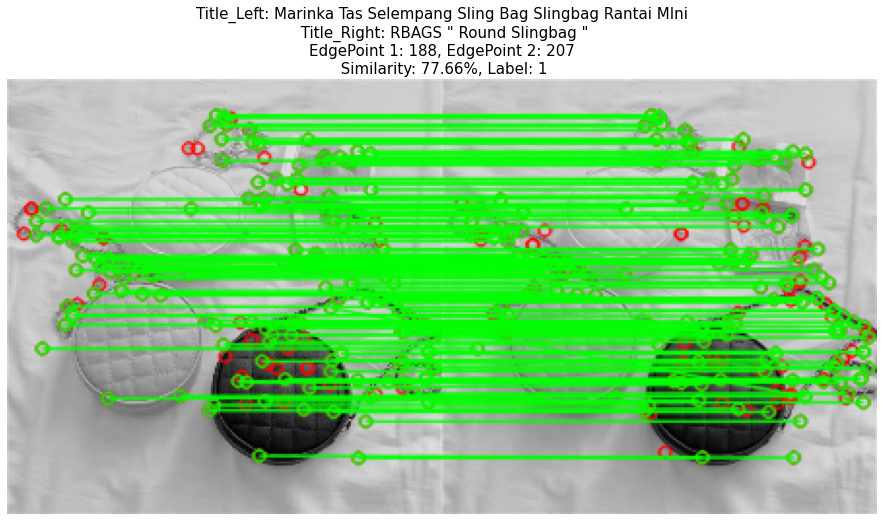

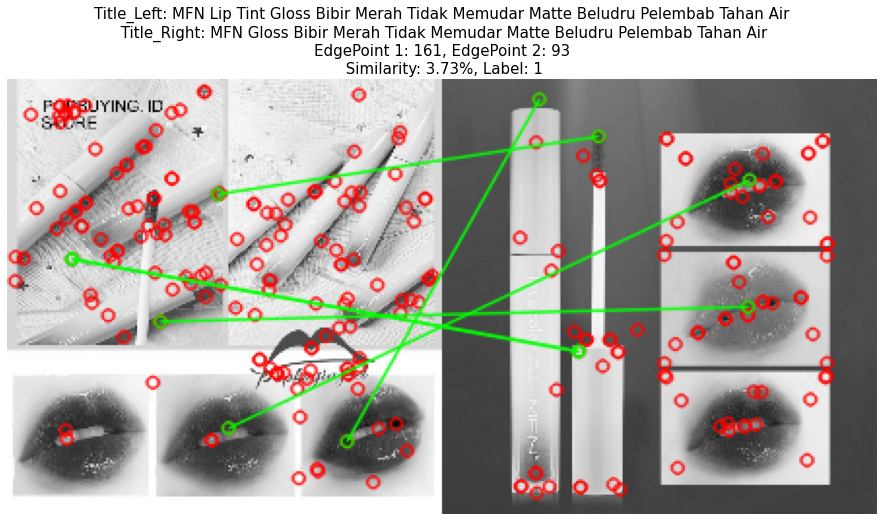

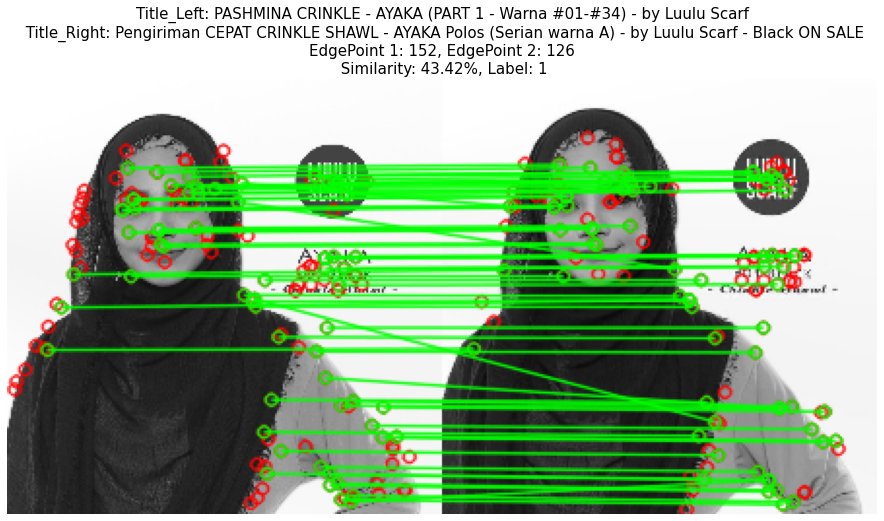

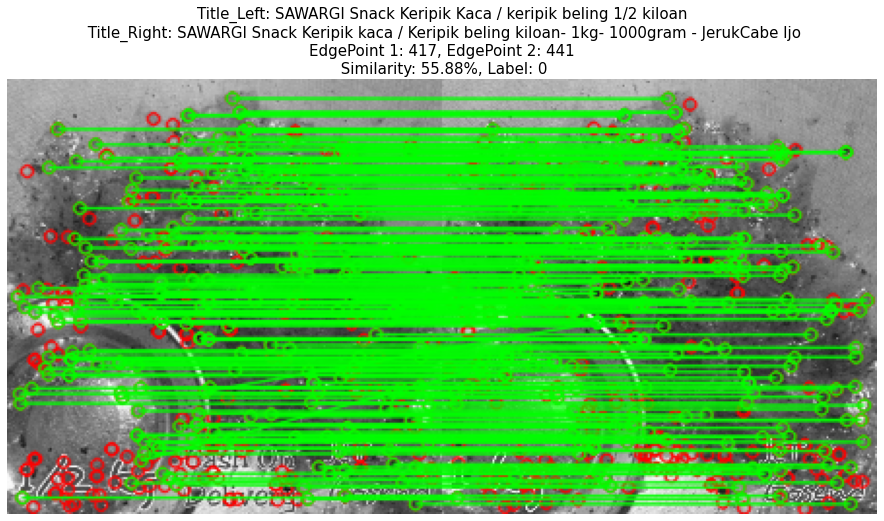

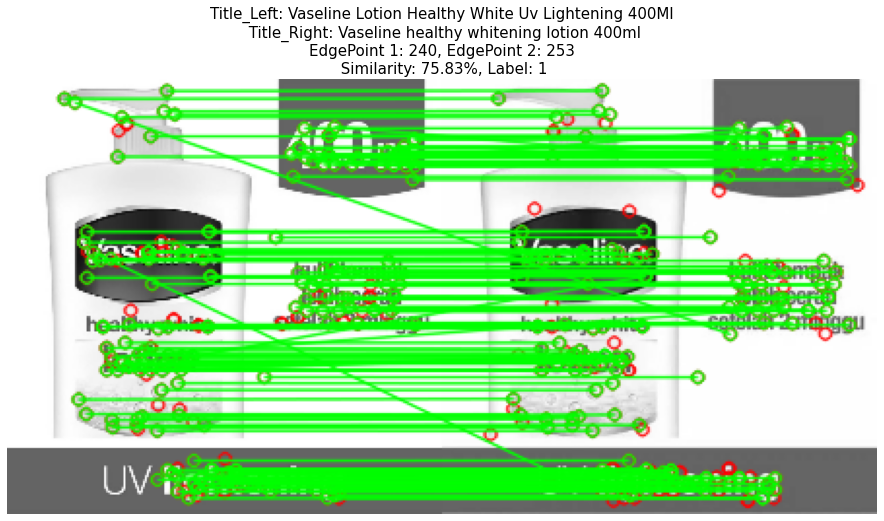

In [4]:
for iterate in range(5): 
    N = random.randint(0,len(df.values))
    feature_match_toolkit(N)

In [5]:
VGG = pd.read_csv('similarity_value.csv')
VGG

,VGG,SSIM
0,0.560240,0.335447
1,0.583799,0.344486
2,0.376315,0.069080
3,0.339931,0.130247
4,0.944269,0.154917
...,...,...
10176,1.000000,1.000000
10177,0.335350,0.196249
10178,0.960847,0.858378
10179,0.773393,0.154674


In [6]:
SIFT = pd.read_csv('SIFT.csv')
SIFT

,kp1,kp2,SIFT_score
0,1171,1171,0.05
1,398,1652,0.04
2,4139,826,0.04
3,4338,4865,0.06
4,2915,2492,0.58
...,...,...,...
10176,1285,1285,1.00
10177,2696,1580,0.01
10178,3082,2429,0.32
10179,1627,872,0.03


In [7]:
train = SIFT
train['VGG'] = VGG['VGG']
train

,kp1,kp2,SIFT_score,VGG
0,1171,1171,0.05,0.560240
1,398,1652,0.04,0.583799
2,4139,826,0.04,0.376315
3,4338,4865,0.06,0.339931
4,2915,2492,0.58,0.944269
...,...,...,...,...
10176,1285,1285,1.00,1.000000
10177,2696,1580,0.01,0.335350
10178,3082,2429,0.32,0.960847
10179,1627,872,0.03,0.773393


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import xgboost
import time
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

X = np.array(train.values).reshape((10181,4))
Y = df['Label'].values

curr_K, curr_best = 0, 0
for K in tqdm(range(200,600)):
    XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size = 0.1, random_state = K)
    XGB = xgboost.XGBClassifier(n_estimators = 50, 
                                    alpha = 0, 
                                    max_depth = 7, 
                                    reg_lambda = 10).fit(XTrain,YTrain.ravel())
    YPred = XGB.predict(XTest)
    f = classification_report(YTest, YPred, output_dict = True)
    if curr_best < np.round(f['macro avg']['f1-score']*10000, 2)/100:
        curr_best = np.round(f['macro avg']['f1-score']*10000, 2)/100
        curr_K = K
                                                         
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size = 0.05, random_state = curr_K)

100%|██████████| 400/400 [02:03<00:00,  3.25it/s]


In [9]:
curr_K, curr_best

(421, 85.94040000000001)

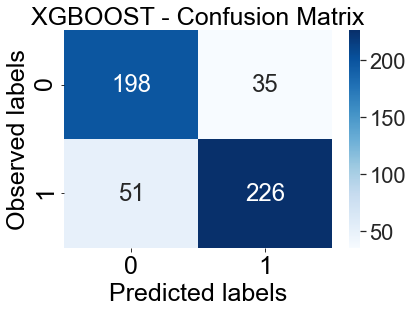

Time	: 0.2 s
Accuracy: 83.13725
f1-score: 83.0863
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       233
           1       0.87      0.82      0.84       277

    accuracy                           0.83       510
   macro avg       0.83      0.83      0.83       510
weighted avg       0.83      0.83      0.83       510



In [10]:
start = time.time()
XGB = xgboost.XGBClassifier(n_estimators = 50, 
                            alpha = 0,
                            max_depth = 4, 
                            reg_lambda = 10).fit(XTrain,YTrain.ravel())
YPred = XGB.predict(XTest)
stop = time.time()

cm = confusion_matrix(YTest,YPred)
fig, ax = plt.subplots()
sns.set(font_scale = 2) # Adjust to fit
sns.heatmap(cm, annot = True, ax = ax, cmap = "Blues", fmt = "g")

# Labels, title and ticks
label_font = {'size':'25'} 
ax.set_xlabel('Predicted labels', fontdict = label_font)
ax.set_ylabel('Observed labels', fontdict = label_font)
ax.set_title('XGBOOST - Confusion Matrix', fontdict = label_font)
ax.xaxis.set_ticklabels(['0', '1'], fontsize = 25)
ax.yaxis.set_ticklabels(['0', '1'], fontsize = 25)

plt.show()

print("Time\t:", round(stop-start,2),"s")
print("Accuracy:", round((cm[0,0]+cm[1,1])/np.sum(cm)*100,5))

f = classification_report(YTest, YPred, output_dict = True)
print("f1-score:", np.round(f['macro avg']['f1-score']*10000, 2)/100)

print(classification_report(YTest, YPred))

In [11]:
test = pd.read_csv('VGGN.csv')
test

,pair_index,kp1,kp2,SIFT_score,VGG
0,0,388,977,0.04,0.551242
1,1,2424,1146,0.00,0.303755
2,2,1786,518,0.01,0.437919
3,3,679,682,0.55,0.997986
4,4,1253,5491,0.03,0.555104
...,...,...,...,...,...
32575,32575,258,1774,0.03,0.450380
32576,32576,2412,1323,0.01,0.186965
32577,32577,1450,1506,0.04,0.630882
32578,32578,473,548,0.66,0.996901


In [12]:
prediction = XGB.predict(test.iloc[:,1:].values.reshape((32580,4)))
result = pd.DataFrame({'pair_index': test.iloc[:,0], 'label':prediction})
# result.to_csv('VGG16-XGB-Full-Prediction.csv', index = False)